# Setup

In [ ]:
!pip install ipympl
from google.colab import output
output.enable_custom_widget_manager()

!pip install ultralytics
!pip install supervision

!git clone https://github.com/ifzhang/ByteTrack.git
%cd /content/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

from IPython import display
display.clear_output()

In [ ]:
%cd /content
import sys
sys.path.append(f"ByteTrack")

/content


In [145]:
!gdown 1AzEu4ISONeXKTgjSlAS12utOfiPFdY6z

Downloading...
From: https://drive.google.com/uc?id=1AzEu4ISONeXKTgjSlAS12utOfiPFdY6z
To: /content/best.pt
100% 22.5M/22.5M [00:00<00:00, 50.9MB/s]


In [146]:
from ultralytics import YOLO

model = YOLO("best.pt")
model.fuse()

Model summary (fused): 168 layers, 11127132 parameters, 0 gradients, 28.4 GFLOPs


# Declare utility classes and functions

In [ ]:
from typing import List

import numpy as np
from supervision import Detections
from onemetric.cv.utils.iou import box_iou_batch
from yolox.tracker.byte_tracker import BYTETracker, STrack



# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

In [191]:
from typing import List, Optional, Union

import cv2
import numpy as np

from supervision.detection.core import Detections
from supervision.draw.color import Color, ColorPalette
from supervision.geometry.core import Position


class MyBoxAnnotator:
    """
    A class for drawing bounding boxes on an image using detections provided.

    Attributes:
        color (Union[Color, ColorPalette]): The color to draw the bounding box,
            can be a single color or a color palette
        thickness (int): The thickness of the bounding box lines, default is 2
        text_color (Color): The color of the text on the bounding box, default is white
        text_scale (float): The scale of the text on the bounding box, default is 0.5
        text_thickness (int): The thickness of the text on the bounding box,
            default is 1
        text_padding (int): The padding around the text on the bounding box,
            default is 5

    """

    def __init__(
        self,
        color: Union[Color, ColorPalette] = ColorPalette.default(),
        thickness: int = 2,
        text_color: Color = Color.black(),
        text_scale: float = 0.5,
        text_thickness: int = 1,
        text_padding: int = 10,
        anchor = "center"
    ):
        self.color: Union[Color, ColorPalette] = color
        self.thickness: int = thickness
        self.text_color: Color = text_color
        self.text_scale: float = text_scale
        self.text_thickness: int = text_thickness
        self.text_padding: int = text_padding
        self.anchor = anchor

    def annotate(
        self,
        scene: np.ndarray,
        detections: Detections,
        labels: Optional[List[str]] = None,
        skip_label: bool = False,
    ) -> np.ndarray:
        """
        Draws bounding boxes on the frame using the detections provided.

        Args:
            scene (np.ndarray): The image on which the bounding boxes will be drawn
            detections (Detections): The detections for which the
                bounding boxes will be drawn
            labels (Optional[List[str]]): An optional list of labels
                corresponding to each detection. If `labels` are not provided,
                corresponding `class_id` will be used as label.
            skip_label (bool): Is set to `True`, skips bounding box label annotation.
        Returns:
            np.ndarray: The image with the bounding boxes drawn on it

        Example:
            ```python
            >>> import supervision as sv

            >>> classes = ['person', ...]
            >>> image = ...
            >>> detections = sv.Detections(...)

            >>> box_annotator = sv.BoxAnnotator()
            >>> labels = [
            ...     f"{classes[class_id]} {confidence:0.2f}"
            ...     for _, _, confidence, class_id, _
            ...     in detections
            ... ]
            >>> annotated_frame = box_annotator.annotate(
            ...     scene=image.copy(),
            ...     detections=detections,
            ...     labels=labels
            ... )
            ```
        """
        font = cv2.FONT_HERSHEY_SIMPLEX
        for i in range(len(detections)):
            x1, y1, x2, y2 = detections.xyxy[i].astype(int)
            class_id = (
                detections.class_id[i] if detections.class_id is not None else None
            )
            idx = class_id if class_id is not None else i
            color = (
                self.color.by_idx(idx)
                if isinstance(self.color, ColorPalette)
                else self.color
            )
            cv2.rectangle(
                img=scene,
                pt1=(x1, y1),
                pt2=(x2, y2),
                color=color.as_bgr(),
                thickness=self.thickness,
            )

            if self.anchor == "center":
                cv2.circle(
                    scene,
                    (int((x2 + x1)/2), y2),
                    radius=5,
                    color=(0, 255, 0),
                    thickness=-1,
                    lineType=cv2.LINE_AA,
                )
            elif self.anchor == "right":
                cv2.circle(
                    scene,
                    (x2, y2),
                    radius=5,
                    color=(0, 0, 255),
                    thickness=-1,
                    lineType=cv2.LINE_AA,
                )
            elif self.anchor == "left":
                cv2.circle(
                    scene,
                    (x1, y2),
                    radius=5,
                    color=(255, 0, 0),
                    thickness=-1,
                    lineType=cv2.LINE_AA,
                )


            if skip_label:
                continue

            text = (
                f"{class_id}"
                if (labels is None or len(detections) != len(labels))
                else labels[i]
            )

            text_width, text_height = cv2.getTextSize(
                text=text,
                fontFace=font,
                fontScale=self.text_scale,
                thickness=self.text_thickness,
            )[0]

            text_x = x1 + self.text_padding
            text_y = y1 - self.text_padding

            text_background_x1 = x1
            text_background_y1 = y1 - 2 * self.text_padding - text_height

            text_background_x2 = x1 + 2 * self.text_padding + text_width
            text_background_y2 = y1

            # cv2.rectangle(
            #     img=scene,
            #     pt1=(text_background_x1, text_background_y1),
            #     pt2=(text_background_x2, text_background_y2),
            #     color=color.as_bgr(),
            #     thickness=cv2.FILLED,
            # )
            # cv2.putText(
            #     img=scene,
            #     text=text,
            #     org=(text_x, text_y),
            #     fontFace=font,
            #     fontScale=self.text_scale,
            #     color=self.text_color.as_rgb(),
            #     thickness=self.text_thickness,
            #     lineType=cv2.LINE_AA,
            # )
        return scene

In [ ]:
import math

def calculate_distance(point_1, point_2):
    return math.sqrt((point_1.x - point_2.x)**2 + (point_1.y - point_2.y)**2)


def calculate_angle_between_lines(A, B, C):
    """ Degree of angle BAC """

    vector_AB = (B.x - A.x, B.y - A.y)
    vector_AC = (C.x - A.x, C.y - A.y)
    dot_product = vector_AB[0] * vector_AC[0] + vector_AB[1] * vector_AC[1]
    magnitude_AB = math.sqrt(vector_AB[0]**2 + vector_AB[1]**2)
    magnitude_AC = math.sqrt(vector_AC[0]**2 + vector_AC[1]**2)
    cosine_theta = dot_product / (magnitude_AB * magnitude_AC)
    theta_radians = math.acos(cosine_theta)
    theta_degrees = math.degrees(theta_radians)

    return theta_degrees

In [256]:
from typing import Dict, Optional

import cv2
import numpy as np

from supervision.detection.core import Detections
from supervision.draw.color import Color
from supervision.geometry.core import Point, Rect, Vector


class MyLineZone:
    """
    Count the number of objects that cross a line.
    """

    def __init__(self, start: Point, end: Point, anchor="center"):
        """
        Initialize a LineCounter object.

        Attributes:
            start (Point): The starting point of the line.
            end (Point): The ending point of the line.

        """
        self.start = start
        self.end = end
        self.vector = Vector(start=start, end=end)
        self.tracker_state: Dict[str, bool] = {}
        self.in_count: int = 0
        self.out_count: int = 0
        self.anchor = anchor

    def loadcount(self,file_path):
      # Check if the file exists
      if not os.path.exists(file_path):
          # Create the file and save the list to a JSON file
          with open(file_path, 'w') as json_file:
              data={'in':0,'out':0}
              json.dump(data, json_file)

      with open(file_path, 'r') as json_file:
          data = json.load(json_file)

      # Access the 'total_in' value
      self.in_count = data['in']
      self.out_count = data['out']


    def trigger(self, detections: Detections):
        """
        Update the in_count and out_count for the detections that cross the line.

        Attributes:
            detections (Detections): The detections for which to update the counts.

        """
        for xyxy, _, confidence, class_id, tracker_id in detections:
            # handle detections with no tracker_id
            if tracker_id is None:
                continue

            x1, y1, x2, y2 = xyxy

            if self.anchor == "center":
                target = Point(int((x2 + x1)/2), y2)
            elif self.anchor == "right":
                target = Point(x2, y2)
            else:
                target = Point(x1, y2)

            tracker_state = self.vector.is_in(point=target)

            # handle new detection
            if tracker_id not in self.tracker_state:
                self.tracker_state[tracker_id] = tracker_state
                continue

            # handle detection on the same side of the line
            if self.tracker_state.get(tracker_id) == tracker_state:
                continue

            self.tracker_state[tracker_id] = tracker_state
            if (tracker_state == True and
                calculate_angle_between_lines(self.start, self.end, target) <= 90 and
                calculate_angle_between_lines(self.end, self.start, target) <= 90):

                self.out_count += 1
            elif (tracker_state == False and
                calculate_angle_between_lines(self.start, self.end, target) <= 90 and
                calculate_angle_between_lines(self.end, self.start, target) <= 90):

                self.in_count += 1


class MyLineZoneAnnotator:
    def __init__(
        self,
        thickness: float = 2,
        color: Color = Color.white(),
        text_thickness: float = 2,
        text_color: Color = Color.black(),
        text_scale: float = 0.5,
        text_offset: float = 1.5,
        text_padding: int = 10,
        custom_in_text: Optional[str] = None,
        custom_out_text: Optional[str] = None,
        way = "out"
    ):
        """
        Initialize the LineCounterAnnotator object with default values.

        Attributes:
            thickness (float): The thickness of the line that will be drawn.
            color (Color): The color of the line that will be drawn.
            text_thickness (float): The thickness of the text that will be drawn.
            text_color (Color): The color of the text that will be drawn.
            text_scale (float): The scale of the text that will be drawn.
            text_offset (float): The offset of the text that will be drawn.
            text_padding (int): The padding of the text that will be drawn.

        """
        self.thickness: float = thickness
        self.color: Color = color
        self.text_thickness: float = text_thickness
        self.text_color: Color = text_color
        self.text_scale: float = text_scale
        self.text_offset: float = text_offset
        self.text_padding: int = text_padding
        self.custom_in_text: str = custom_in_text
        self.custom_out_text: str = custom_out_text
        self.way = way

    def annotate(self, frame: np.ndarray, line_counter: MyLineZone) -> np.ndarray:
        """
        Draws the line on the frame using the line_counter provided.

        Attributes:
            frame (np.ndarray): The image on which the line will be drawn.
            line_counter (LineCounter): The line counter
                that will be used to draw the line.

        Returns:
            np.ndarray: The image with the line drawn on it.

        """
        cv2.line(
            frame,
            line_counter.vector.start.as_xy_int_tuple(),
            line_counter.vector.end.as_xy_int_tuple(),
            self.color.as_bgr(),
            self.thickness,
            lineType=cv2.LINE_AA,
            shift=0,
        )
        cv2.circle(
            frame,
            line_counter.vector.start.as_xy_int_tuple(),
            radius=5,
            color=self.text_color.as_bgr(),
            thickness=-1,
            lineType=cv2.LINE_AA,
        )
        cv2.circle(
            frame,
            line_counter.vector.end.as_xy_int_tuple(),
            radius=5,
            color=self.text_color.as_bgr(),
            thickness=-1,
            lineType=cv2.LINE_AA,
        )
        in_text = (
            f"{self.custom_in_text}: {line_counter.in_count}"
            if self.custom_in_text is not None
            else f"in: {line_counter.in_count}"
        )
        out_text = (
            f"{self.custom_out_text}: {line_counter.out_count}"
            if self.custom_out_text is not None
            else f"out: {line_counter.out_count}"
        )


        (in_text_width, in_text_height), _ = cv2.getTextSize(
            in_text, cv2.FONT_HERSHEY_SIMPLEX, self.text_scale, self.text_thickness
        )
        (out_text_width, out_text_height), _ = cv2.getTextSize(
            out_text, cv2.FONT_HERSHEY_SIMPLEX, self.text_scale, self.text_thickness
        )


        in_text_x = int(
            (line_counter.vector.end.x + line_counter.vector.start.x - in_text_width)
            / 2
        )
        in_text_y = int(
            (line_counter.vector.end.y + line_counter.vector.start.y + in_text_height)
            / 2
            - self.text_offset * in_text_height
        )
        out_text_x = int(
            (line_counter.vector.end.x + line_counter.vector.start.x - out_text_width)
            / 2
        )
        out_text_y = int(
            (line_counter.vector.end.y + line_counter.vector.start.y + out_text_height)
            / 2
            + self.text_offset * out_text_height
        )

        in_text_background_rect = Rect(
            x=in_text_x,
            y=in_text_y - in_text_height,
            width=in_text_width,
            height=in_text_height,
        ).pad(padding=self.text_padding)

        out_text_background_rect = Rect(
            x=out_text_x,
            y=out_text_y - out_text_height,
            width=out_text_width,
            height=out_text_height,
        ).pad(padding=self.text_padding)

        cv2.rectangle(
            frame,
            out_text_background_rect.top_left.as_xy_int_tuple(),
            out_text_background_rect.bottom_right.as_xy_int_tuple(),
            self.color.as_bgr(),
            -1,
        )
        cv2.rectangle(
            frame,
            in_text_background_rect.top_left.as_xy_int_tuple(),
            in_text_background_rect.bottom_right.as_xy_int_tuple(),
            self.color.as_bgr(),
            -1,
        )
        cv2.putText(
            frame,
            in_text,
            (in_text_x, in_text_y),
            cv2.FONT_HERSHEY_SIMPLEX,
            self.text_scale,
            self.text_color.as_bgr(),
            self.text_thickness,
            cv2.LINE_AA,
        )
        cv2.putText(
            frame,
            out_text,
            (out_text_x, out_text_y),
            cv2.FONT_HERSHEY_SIMPLEX,
            self.text_scale,
            self.text_color.as_bgr(),
            self.text_thickness,
            cv2.LINE_AA,
        )
        return frame


In [237]:
from dataclasses import dataclass
from onemetric.cv.utils.iou import box_iou_batch
from yolox.tracker.byte_tracker import BYTETracker, STrack


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.5
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 1.6
    min_box_area: float = 10
    mot20: bool = False

# Preprocess video

In [238]:
from supervision import (
    ColorPalette,
    Color,
    Point,
    get_video_frames_generator,
    VideoInfo,
    VideoSink
)

In [239]:
import matplotlib
import matplotlib.pyplot as plt

In [240]:
def get_video_shape(video_path):
    generator = get_video_frames_generator(video_path)
    iterator = iter(generator)
    frame = next(iterator)
    return frame.shape

In [241]:

thickness = 2
text_thickness = 2
text_scale = 1

# Draw lines on video and plot

In [242]:
# !gdown 1mPBcuw56jU8-zG0FRGjsIDCFKZMIOsLG -O cam1.mp4
# !gdown 12gpVcMxDqXVeywupmLKEOxoFrg6Bczu_ -O cam2.mp4

!gdown 1P23ddH37GRLemUik-N7ELzMtEYze13rj -O cam1.mp4
!gdown 1P23ddH37GRLemUik-N7ELzMtEYze13rj -O cam2.mp4

# !gdown 1lx2ZdPgiWspv1XzK6ZZ7dzlJsoqhXNSb -O cam1.mp4
# !gdown 10CUqLIVCdW395bya_QcTkkXWEp7pyk-3 -O cam2.mp4

Downloading...
From: https://drive.google.com/uc?id=1P23ddH37GRLemUik-N7ELzMtEYze13rj
To: /content/cam1.mp4
100% 1.53M/1.53M [00:00<00:00, 11.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1P23ddH37GRLemUik-N7ELzMtEYze13rj
To: /content/cam2.mp4
100% 1.53M/1.53M [00:00<00:00, 11.6MB/s]


## First Camera

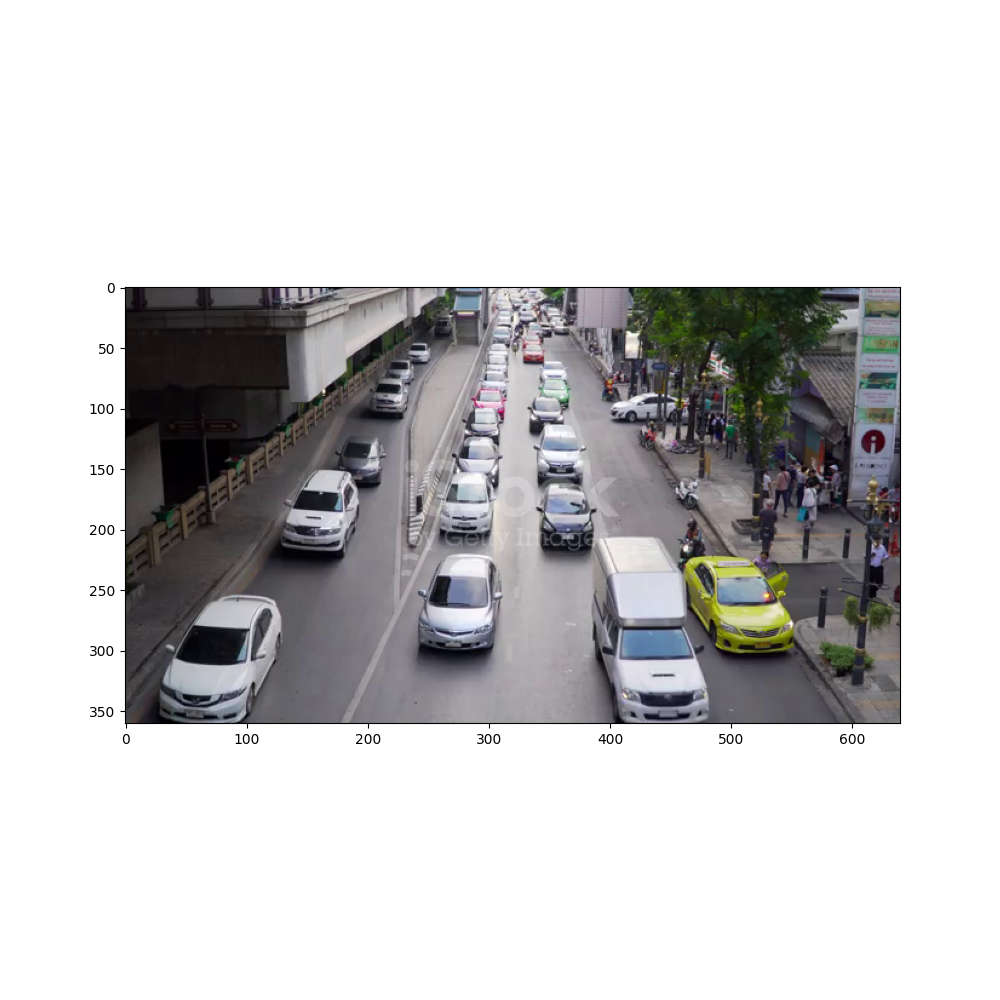

In [243]:
%matplotlib ipympl

generator = get_video_frames_generator("cam1.mp4")

iterator = iter(generator)
frame = next(iterator)

fig = plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

def on_click(event):
    ix, iy = event.xdata, event.ydata
    print(f"Point({round(ix)}, {round(iy)})")

cid = fig.canvas.mpl_connect('button_press_event', on_click)

In [244]:
line_start = Point(63, 212)


line_end = Point(307, 252)

In [245]:
%%capture
%matplotlib inline

# Change mode and clear output
plt.figure(figsize=(8, 8))
plt.show()

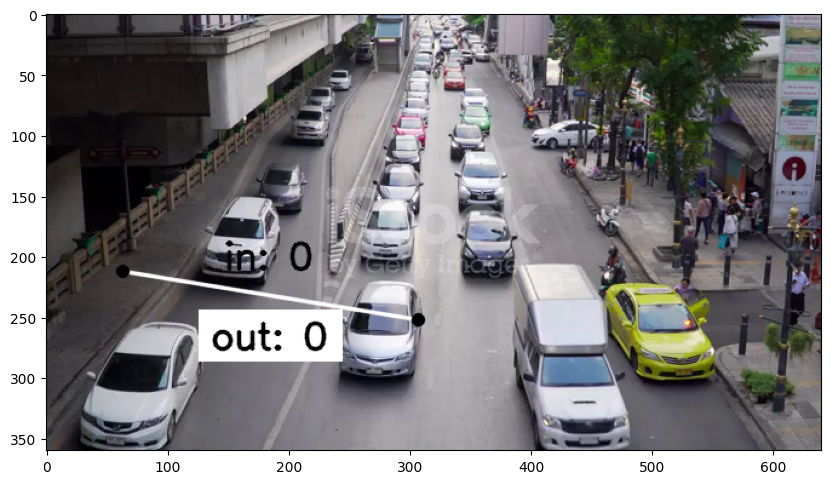

(360, 640, 3)

In [246]:
line_counter = MyLineZone(start=line_start, end=line_end)
line_annotator = MyLineZoneAnnotator(thickness=thickness,
                                   text_thickness=text_thickness,
                                   text_scale=text_scale)
line_annotator.annotate(frame=frame, line_counter=line_counter)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()
frame.shape

## Second Camera

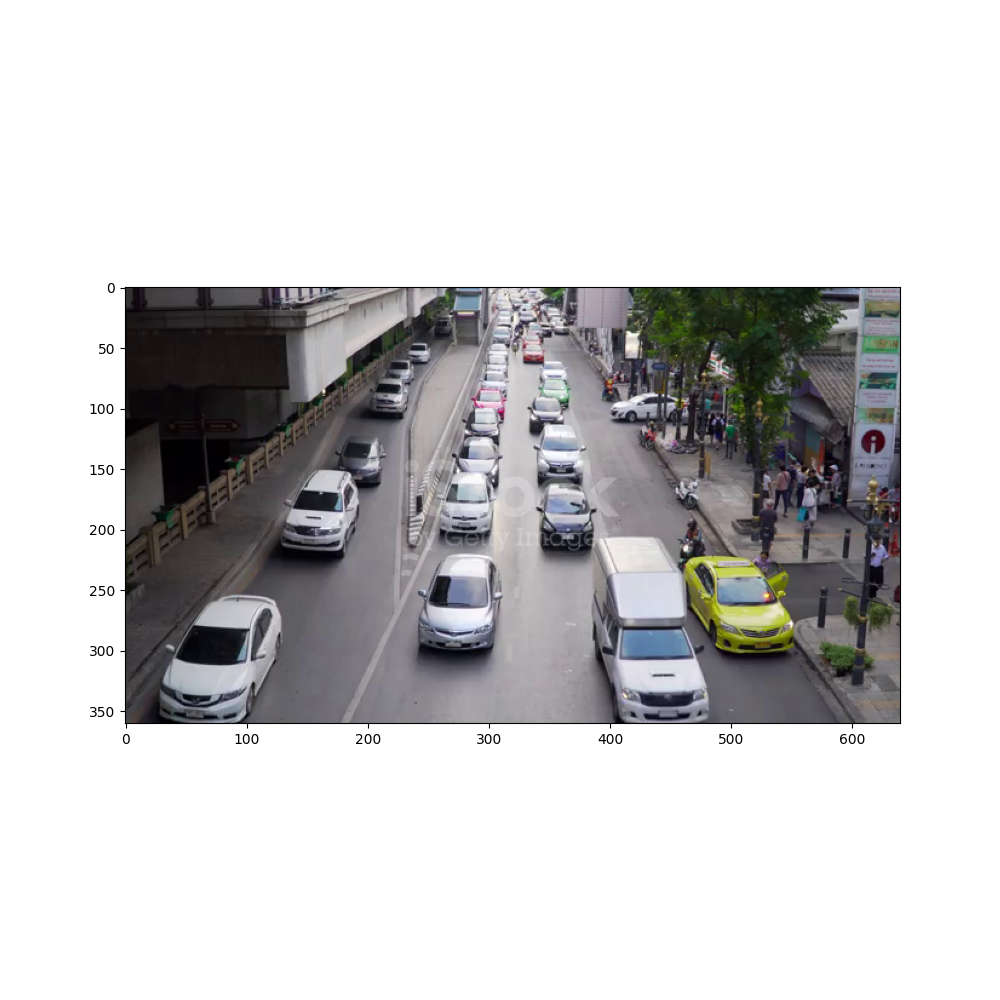

In [247]:
%matplotlib ipympl

generator = get_video_frames_generator("cam2.mp4")

iterator = iter(generator)
frame = next(iterator)

fig = plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

def on_click(event):
    ix, iy = event.xdata, event.ydata
    print(f"Point({round(ix)}, {round(iy)})")

cid = fig.canvas.mpl_connect('button_press_event', on_click)

In [248]:
line_start_2 = Point(319, 248)


line_end_2 = Point(592, 249)

In [249]:
%%capture
%matplotlib inline

# Change mode and clear output
plt.figure(figsize=(10, 10))
plt.show()

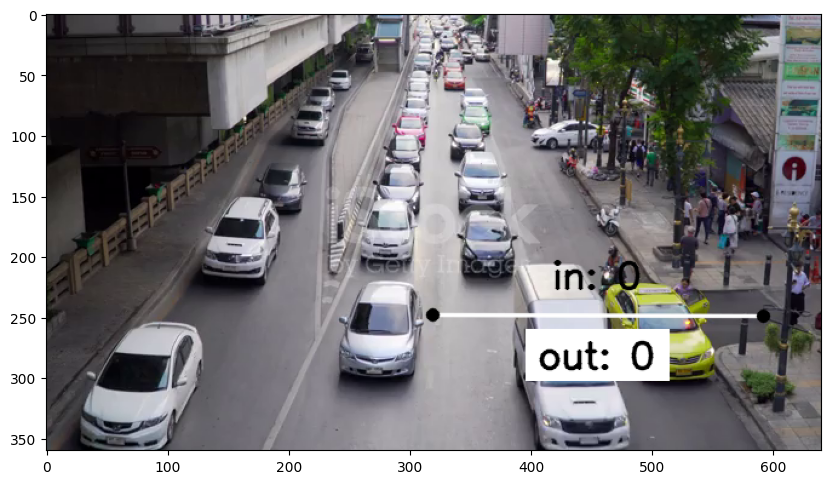

(360, 640, 3)

In [250]:
line_counter = MyLineZone(start=line_start_2, end=line_end_2)
line_annotator = MyLineZoneAnnotator(thickness=thickness,
                                   text_thickness=text_thickness,
                                   text_scale=text_scale)
line_annotator.annotate(frame=frame, line_counter=line_counter)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()
frame.shape

# Get tracking video

In [251]:
def frame2detections(model, frame, tracker):
    results = model(frame, verbose=False)
    detections = Detections(
        xyxy=results[0].boxes.xyxy.cpu().numpy(),
        confidence=results[0].boxes.conf.cpu().numpy(),
        class_id=results[0].boxes.cls.cpu().numpy().astype(int)
    )


    tracks = tracker.update(
        output_results=detections2boxes(detections=detections),
        img_info=frame.shape,
        img_size=frame.shape
    )
    tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
    detections.tracker_id = np.array(tracker_id)

    mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
    detections = detections[mask]

    return detections

In [257]:
import cv2
import numpy as np
from tqdm.notebook import tqdm
import time
import json,os
from datetime import datetime



start_time = time.time()
file_path = 'countscam1.json'
file_path2 = 'countscam2.json'


box_annotator = MyBoxAnnotator(color=ColorPalette.default(),
                               thickness=thickness,
                               text_thickness=text_thickness,
                               text_scale=text_scale,
                               anchor="center")
box_annotator_2 = MyBoxAnnotator(color=ColorPalette.default(),
                               thickness=thickness,
                               text_thickness=text_thickness,
                               text_scale=text_scale,
                               anchor="center")

line_annotator = MyLineZoneAnnotator(thickness=thickness,
                                    text_thickness=text_thickness,
                                    text_scale=text_scale)

line_counter = MyLineZone(start=line_start, end=line_end, anchor="center")
line_counter_2 = MyLineZone(start=line_start_2, end=line_end_2, anchor="center")

byte_tracker = BYTETracker(BYTETrackerArgs())
byte_tracker_2 = BYTETracker(BYTETrackerArgs())

video_info = VideoInfo.from_video_path("/content/cam1.mp4")
video_info_2 = VideoInfo.from_video_path("/content/cam2.mp4")

generator = get_video_frames_generator("/content/cam1.mp4")
generator_2 = get_video_frames_generator("/content/cam2.mp4")
video_info.width = video_info.width * 2
frame_interval=20

#load total count
line_counter.loadcount(file_path)
line_counter_2.loadcount(file_path2)


with VideoSink("tracking_cam.mp4", video_info) as sink:
#     with VideoSink("tracking_cam2.mp4", video_info_2) as sink_2:
    for idx,(frame, frame_2) in tqdm(enumerate(zip(generator, generator_2)), total=video_info.total_frames):
        # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        detections = frame2detections(model, frame, byte_tracker)

        # frame_2 = cv2.cvtColor(frame_2, cv2.COLOR_BGR2RGB)
        detections_2 = frame2detections(model, frame_2, byte_tracker_2)


        #     f"#{tracker_id}-{class_names_dict[class_id]}"
        labels = [
            f"#{tracker_id}"
            for __, __, confidence, class_id, tracker_id
            in detections
        ]
        labels_2 = [
            f"#{tracker_id}"
            for __, __, confidence, class_id, tracker_id
            in detections_2
        ]

        line_counter.trigger(detections=detections)
        line_counter_2.trigger(detections=detections_2)

        total_in =line_counter.in_count+line_counter_2.in_count
        total_out = line_counter.out_count+line_counter_2.out_count

        cv2.putText(frame, f'Total In: {total_in}', (400, 60), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)
        cv2.putText(frame, f'Total Out: {total_out}', (400, 120), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)

        line_annotator.annotate(frame=frame, line_counter=line_counter)
        line_annotator.annotate(frame=frame_2, line_counter=line_counter_2)

        frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
        frame_2 = box_annotator_2.annotate(scene=frame_2, detections=detections_2, labels=labels_2)
        end_time = time.time()
        fps = 1 / (end_time - start_time)
        start_time = end_time
        cv2.putText(frame, f'FPS: {fps:.2f}', (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, ( 255, 0,0), 2)

        merged_frame = np.concatenate((frame, frame_2), axis=1)
        sink.write_frame(merged_frame)
        if idx % frame_interval != 0 :
                continue
        current_time = datetime.now()
        formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")
        data={'in':line_counter.in_count, 'out':line_counter.out_count,'time':formatted_time }
        data2={'in':line_counter_2.in_count, 'out':line_counter_2.out_count,'time':formatted_time }
        with open(file_path, 'w') as json_file:
          json.dump(data, json_file)
        with open(file_path2, 'w') as json_file:
          json.dump(data2, json_file)





    #     plt.figure(figsize=(15, 15))

    #     plt.imshow(merged_frame)

    # # plt.subplot(1, 2, 1)
    # # plt.imshow(frame)
    # # plt.subplot(1, 2, 2)
    # # plt.imshow(frame_2)
    # # plt.tight_layout()

    #     plt.show()
    #     break


  0%|          | 0/261 [00:00<?, ?it/s]

In [258]:
!ffmpeg -i "tracking_cam.mp4" -crf 28 -preset veryfast \
        -hide_banner -loglevel error -vcodec libx264 "final_cam.mp4" -y

In [259]:
# from IPython.display import HTML
# from base64 import b64encode


# mp4 = open("final_cam.mp4", "rb").read()
# data_url = "data:video/webm;base64," + b64encode(mp4).decode()
# HTML(f"""
# <video width=1200 controls>
#       <source src="{data_url}" type="video/webm">
# </video>
# """)

In [260]:
from google.colab import drive
drive.mount('/content/drive')
!cp final_cam.mp4 /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [235]:
# # Display image and videos
# import IPython
# from IPython.display import Video, display

# Video(data=web_video_path, embed=True)